In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib nbagg
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from pathlib import Path

import haiku as hk
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'
import jax
from jax.experimental import optix
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from nsec.normalization import SNParamsTree as CustomSNParamsTree
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except IndexError:
    pass
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from tqdm.notebook import tqdm

os.environ['SINGLECOIL_TRAIN_DIR'] = 'singlecoil_train/singlecoil_train/'
from tf_fastmri_data.datasets.cartesian import CartesianFastMRIDatasetBuilder
from tf_fastmri_data.datasets.noisy import ComplexNoisyFastMRIDatasetBuilder
from nsec.models.dae.convdae import SmallUResNet
from nsec.mri.fourier import FFT2
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

In [2]:
plt.rcParams['image.cmap'] = 'gray'

In [3]:
batch_size = 32
common_kwargs = dict(
    brain=False,
    scale_factor=1e6,
    slice_random=True,
    kspace_size=(320, 320),
)
noise_kwargs = dict(
    noise_power_spec=30,
    noise_input=True,
    noise_mode='gaussian',
    residual_learning=True,
#     normal_noise_output=False,
    batch_size=batch_size,
    **common_kwargs,
)

train_mri_ds = ComplexNoisyFastMRIDatasetBuilder(
    dataset='train', 
    **noise_kwargs,
)
n_steps = 400
mri_images_iterator = train_mri_ds.preprocessed_ds.take(n_steps).as_numpy_iterator()

val_mri_ds = ComplexNoisyFastMRIDatasetBuilder(
    dataset='val',
    **noise_kwargs
)
val_mri_images_iterator = val_mri_ds.preprocessed_ds.as_numpy_iterator()


val_mri_recon_ds = CartesianFastMRIDatasetBuilder(
    dataset='val',
    af=4,
    **common_kwargs,
)
val_mri_recon_iterator = val_mri_recon_ds.preprocessed_ds.as_numpy_iterator()
##### BATCH DEFINITION
# (image_noisy, noise_power), noise_realisation
# here the noise_realisation is the full one, not the epsilon from the standard normal law

In [4]:
def forward(x, s, is_training=False):
    denoiser = SmallUResNet(use_bn=True, n_output_channels=2)
    x = jnp.concatenate([x.real, x.imag], axis=-1)
    denoised_float = denoiser(x, s, is_training=is_training)
    denoised_complex = denoised_float[..., 0] + 1j * denoised_float[..., 1]
    denoised_complex = denoised_complex[..., None]
    return denoised_complex

model = hk.transform_with_state(forward)

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [5]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [6]:
params, state = model.init(next(rng_seq), jnp.zeros((1, 32, 32, 1), dtype=jnp.complex64), jnp.zeros((1, 1, 1, 1)), is_training=True)
opt_state = optimizer.init(params)

_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

/volatile/home/Zaccharie/workspace/score-estimation-comparison/venv/lib/python3.6/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [7]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    (x, s), su = batch
    # this to stick to the original shape of the noise power
    s = s[..., None, None, None]
    res, state = model.apply(params, state, rng_key, x, s, is_training=True)
    real_loss = jnp.mean((su.real / s + s * res.real)**2)
    imag_loss = jnp.mean((su.imag / s + s * res.imag)**2)
    loss = real_loss + imag_loss
    # we therefore have res ~ - su / s**2, which means that x_hat = x' + res * s**2 (because we have x' = x + su)
    return loss, state

In [8]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [9]:
losses = []

In [10]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [11]:
# for step, batch in tqdm(enumerate(mri_images_iterator), total=n_steps):
#     loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
#     losses.append(loss)
#     if step%100==0:
#         print(step, loss)

<IPython.core.display.Javascript object>


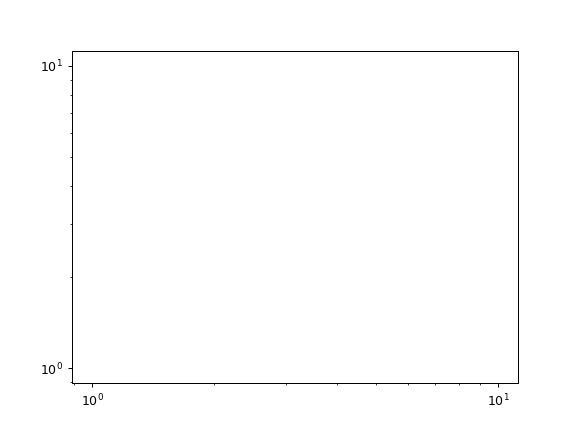

In [12]:
plt.figure()
plt.loglog(losses[10:])

In [13]:
# Saving params
import pickle

# with open('conv-dae-L2-mri-partial-training.pckl', 'wb') as file:
#     pickle.dump([params, state, sn_state], file)

In [14]:
# Importing saved model
with open('../conv-dae-L2-mri-30.0.pckl', 'rb') as file:
    params, state, sn_state = pickle.load(file)

In [15]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [16]:
(x, s), su = next(val_mri_images_iterator)
s = s[..., None, None, None]
res, state = score(x, s, is_training=False)

<IPython.core.display.Javascript object>


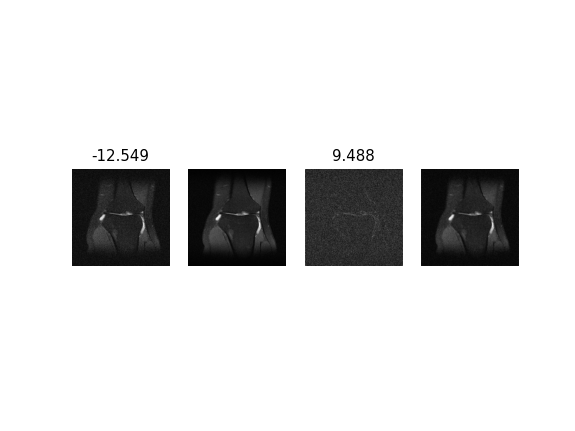

<IPython.core.display.Javascript object>


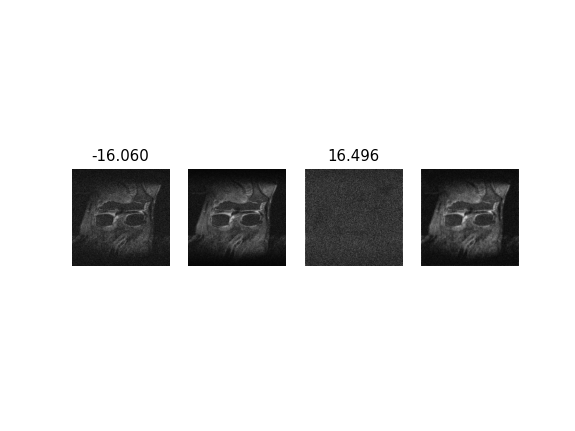

<IPython.core.display.Javascript object>


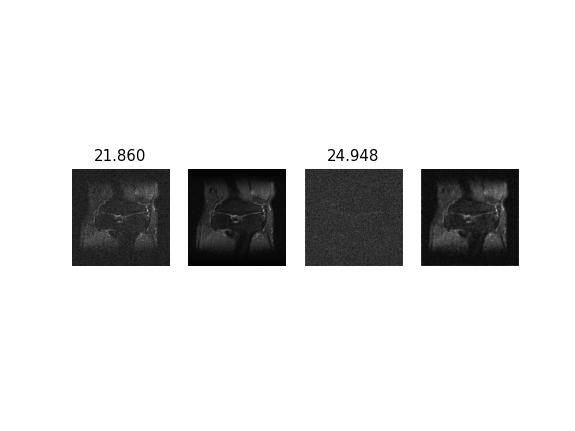

<IPython.core.display.Javascript object>


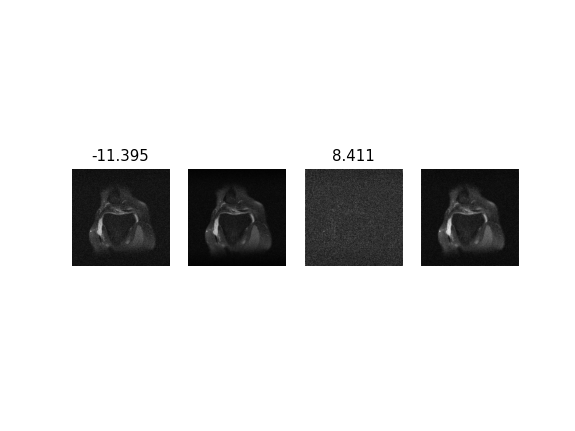

<IPython.core.display.Javascript object>


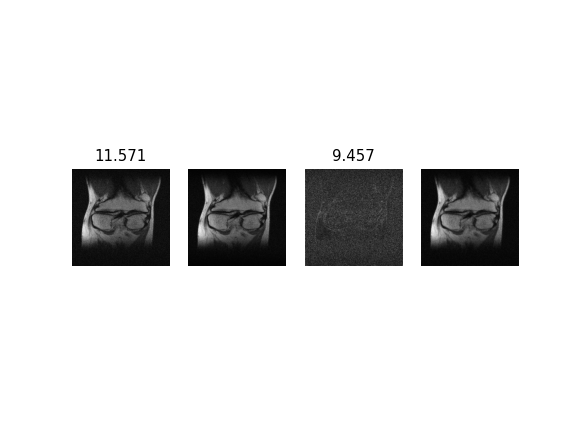

<IPython.core.display.Javascript object>


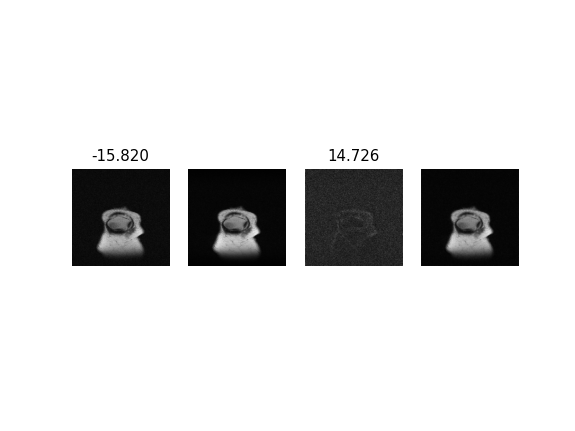

<IPython.core.display.Javascript object>


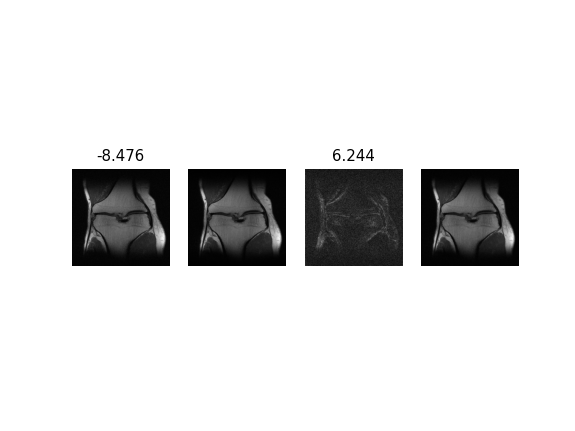

<IPython.core.display.Javascript object>


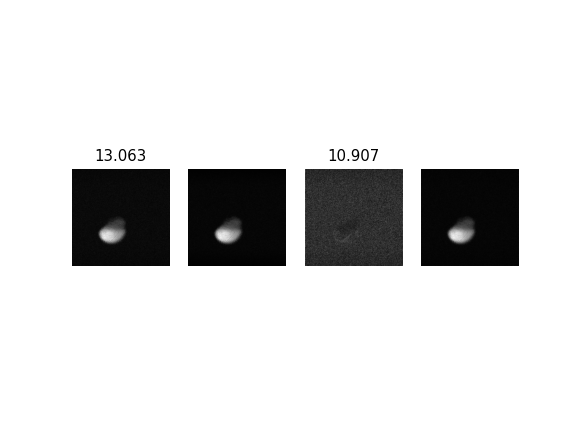

<IPython.core.display.Javascript object>


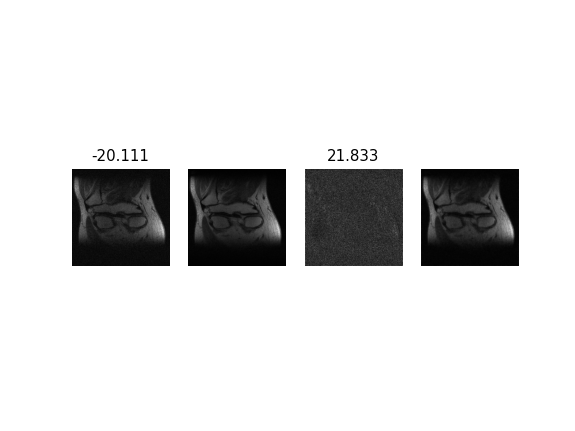

<IPython.core.display.Javascript object>


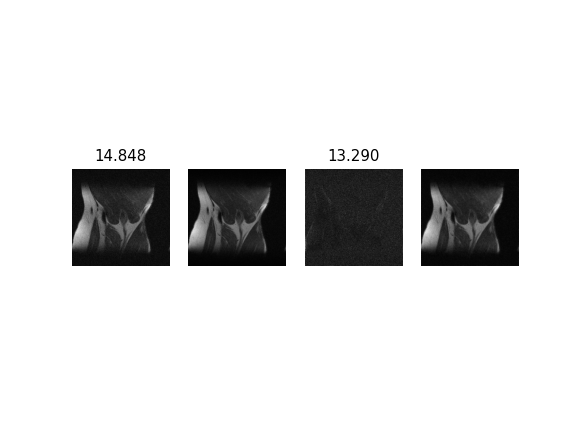

In [17]:
for i in range(10):
    ind = i
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
    axs[0].set_title("%0.3f"%s[ind,0,0,0])
    axs[0].imshow(jnp.abs(x)[ind,...,0],cmap='gray')
    axs[0].axis('off')
    axs[1].imshow(jnp.abs(x - su)[ind,...,0],cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(jnp.abs(res)[ind,...,0],cmap='gray')
    axs[2].axis('off')
    axs[2].set_title("%0.3f"%jnp.std(s[ind,:,:,0]**2 *res[ind,...,0]))
    axs[3].imshow(jnp.abs(x[ind,...,0] + s[ind,:,:,0]**2 * res[ind,...,0]),cmap='gray')
    axs[3].axis('off')

In [18]:
# Trying to sample from the model

<IPython.core.display.Javascript object>


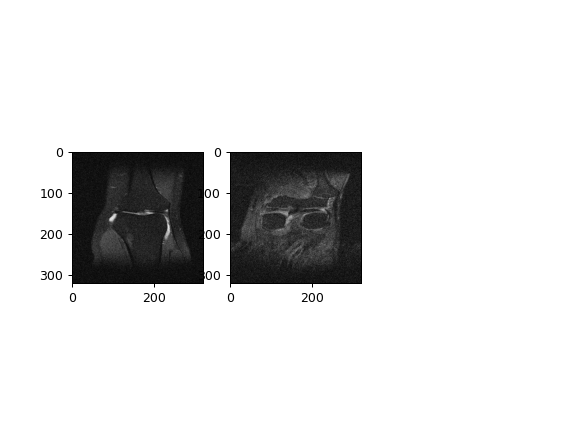

In [19]:
plt.figure()
plt.subplot(131)
plt.imshow(jnp.abs(x)[0,...,0].reshape((320,320,)))
plt.subplot(132)
plt.imshow(jnp.abs(x)[1,...,0].reshape((320,320,)))
# subplot(133)
# imshow(x[2,...,0].reshape((320,320,)))

In [138]:
# this is where I will need to add data consistency
l = 1e-1
temp = 1*1e0
def score_fn(x, y=None, mask=None, mode='prior'):
    """x is a float tensor, with imag and real concatenated in the channel axis
    """
    if y is None:
        w, h = 320, 320
    else:
        w, h = y.shape
    x_reshaped = x.reshape((1, w, h, 2))
    x_reshaped = x_reshaped[..., 0] + 1j * x_reshaped[..., 1]
    x_reshaped = x_reshaped[..., None]
    
    prior = score(x_reshaped, jnp.zeros((1,1,1,1))+temp, is_training=False)[0]
    if mode == 'prior':
        out = prior
    elif mode == 'data_consistency':
        assert y is not None
        assert mask is not None
        fourier_obj = FFT2(mask)
        data_consistency = fourier_obj.adj_op(fourier_obj.op(x_reshaped[..., 0]) - y)
        data_consistency = data_consistency[..., None]
        ####
        # NOTE
        ####
        # how to deal with scaling in the subsequent addition?
        out = prior + l * data_consistency
    out_float = jnp.concatenate([out.real, out.imag], axis=-1)
    out_reshaped = out_float.reshape((w*h*2,))
    return out_reshaped

In [139]:
# first let's look at the prior

In [140]:
num_results = int(1e3)
num_burnin_steps = int(1e1)

In [154]:
@partial(jax.jit, static_argnums=(1, 2, 3))
def get_samples(x, y=None, mask=None, mode='prior'):
    """x is a complex tensor
    """
    # First running SHMC
    kernel_shmc = ScoreHamiltonianMonteCarlo(
            target_score_fn=partial(score_fn, y=y, mask=mask, mode=mode),
            num_leapfrog_steps=4,
            num_delta_logp_steps=4,
            step_size=1e-2,
    )
    x_float = jnp.concatenate([x.real, x.imag], axis=-1)
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state= x_float[0].reshape((jnp.prod(x_float[0].shape),)),
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
          seed=jax.random.PRNGKey(1),
    )
    return samples_shmc, is_accepted_shmc

In [155]:
# samples_shmc, is_accepted_shmc = get_samples(x, None, None, 'prior')

In [156]:
# %%time
# samples_shmc = samples_shmc.block_until_ready()
# is_accepted_shmc = is_accepted_shmc.block_until_ready()

In [157]:
# len(jnp.where(is_accepted_shmc)[0])

In [158]:
# samples_shmc = samples_shmc[jnp.where(is_accepted_shmc)[0]]

In [159]:
# fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
# axs[0].imshow(jnp.linalg.norm(samples_shmc[0].reshape((320, -1, 2)), axis=-1), vmin=30, vmax=100)
# axs[-1].imshow(jnp.linalg.norm(samples_shmc[-1].reshape((320, -1, 2)), axis=-1), vmin=30, vmax=100)

In [160]:
# plt.figure(figsize=(20, 20))
# for i in range(20):
#   for j in range(20):
#     plt.subplot(20,20,20*i+j+1)
#     plt.imshow(jnp.linalg.norm(samples_shmc[(20*i+j)].reshape((320, -1, 2)), axis=-1))
#     plt.axis('off')

In [161]:
# now let's look at the posterior

In [162]:
(kspace, mask), image = next(val_mri_recon_iterator)
fourier_obj = FFT2(jnp.tile(mask, [1, kspace.shape[1], 1]))
x = fourier_obj.adj_op(kspace[..., 0])[..., None]

/volatile/home/Zaccharie/workspace/score-estimation-comparison/venv/lib/python3.6/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [163]:
%%time
samples_shmc_post, is_accepted_shmc_post = get_samples(x, kspace[0, ..., 0], mask[0], 'data_consistency')

CPU times: user 54.9 s, sys: 13.2 s, total: 1min 8s
Wall time: 1min 8s


In [164]:
%%time
samples_shmc_post = samples_shmc_post.block_until_ready()
is_accepted_shmc_post = is_accepted_shmc_post.block_until_ready()

CPU times: user 9.93 ms, sys: 4.49 ms, total: 14.4 ms
Wall time: 6.23 ms


In [165]:
len(jnp.where(is_accepted_shmc_post)[0])

962

In [166]:
samples_shmc_post = samples_shmc_post[jnp.where(is_accepted_shmc_post)[0]]

<IPython.core.display.Javascript object>


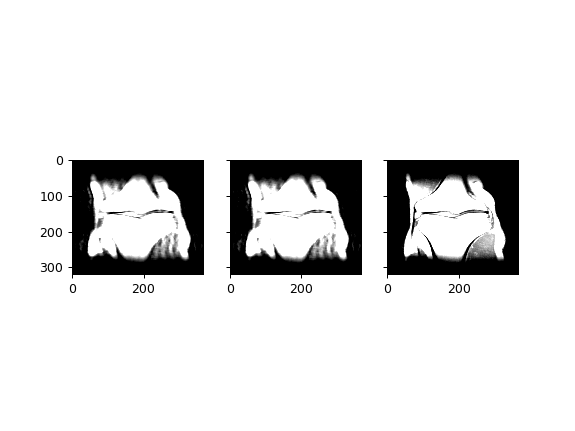

In [167]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].imshow(jnp.abs(x[0]), vmin=30, vmax=100)
axs[1].imshow(jnp.linalg.norm(samples_shmc_post[-1].reshape((320, -1, 2)), axis=-1), vmin=30, vmax=100)
axs[2].imshow(image[0], vmin=30, vmax=100)

<IPython.core.display.Javascript object>


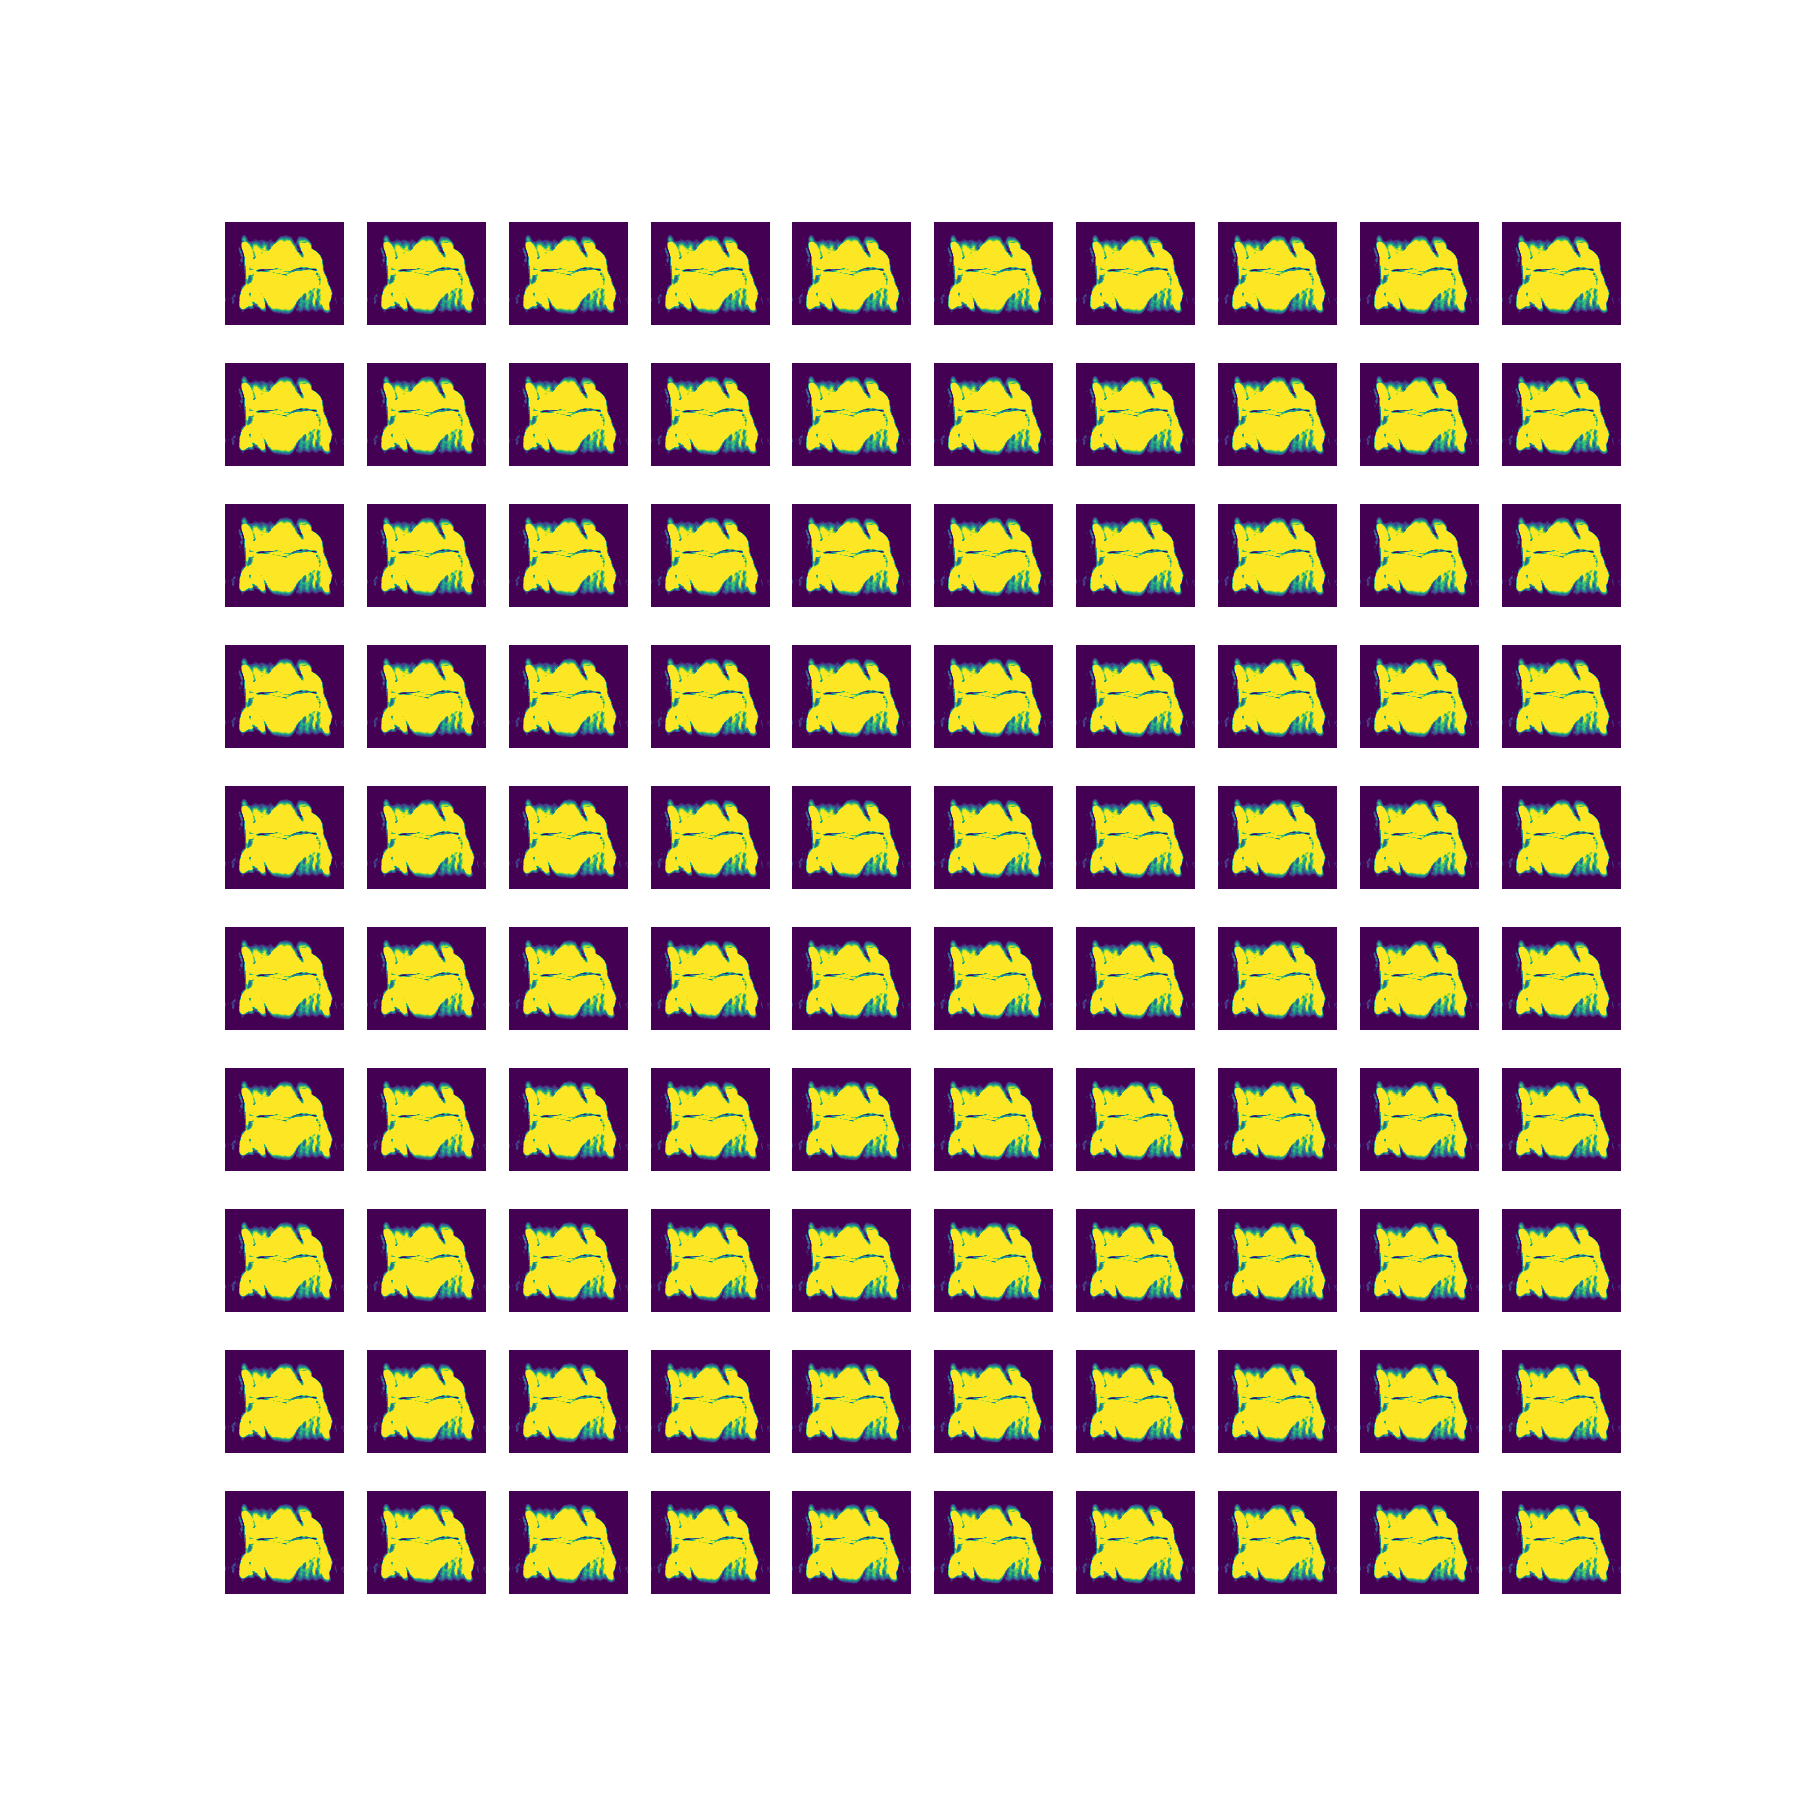

In [168]:
n = 10
fig, axs = plt.subplots(n, n, sharex=True, sharey=True, figsize=(20, 20))
for i in range(n):
  for j in range(n):
    axs[i, j].imshow(jnp.linalg.norm(samples_shmc_post[10*(n*i + j)].reshape((320, -1, 2)), axis=-1), vmin=30, vmax=100, cmap='viridis')
    axs[i, j].axis('off')